# Test GEModelTools - HANC

This notebook shows how to **solve a simple Heterogenous Agent Neo-Classical (HANC) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANCModel import HANCModelClass

# Setup

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [3]:
print(model) # take a look inside

Modelclass: HANCModelClass
Name: baseline

namespaces: ['par', 'ini', 'sim', 'ss', 'path']
other_attrs: ['par', 'ini', 'ss', 'path', 'sim', 'grids_hh', 'pols_hh', 'inputs_hh', 'inputs_hh_z', 'outputs_hh', 'intertemps_hh', 'shocks', 'unknowns', 'targets', 'varlist', 'jac', 'H_U', 'H_Z', 'jac_hh', 'IRF']
savefolder: saved
cpp_filename: None

par:
 Nfix = 1 [int]
 Nz = 7 [int]
 sigma = 2.0 [float]
 beta_mean = 0.9875 [float]
 beta_delta = 0.0 [float]
 rho_z = 0.95 [float]
 sigma_psi = 0.09367496997597599 [float]
 alpha = 0.36 [float]
 delta = nan [float]
 r_ss_target = 0.01 [float]
 w_ss_target = 1.0 [float]
 a_max = 500.0 [float]
 Na = 300 [int]
 jump_Gamma = -0.01 [float]
 rho_Gamma = 0.8 [float]
 std_Gamma = 0.01 [float]
 T = 500 [int]
 simT = 2000 [int]
 max_iter_solve = 50000 [int]
 max_iter_simulate = 50000 [int]
 max_iter_broyden = 100 [int]
 tol_solve = 1e-12 [float]
 tol_simulate = 1e-12 [float]
 tol_broyden = 1e-10 [float]
 Nbeta = 1 [int]
 beta_grid = ndarray with shape = (1,) 

# Step 1: Find Steady state

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions `ss.a` and `ss.c`
1. The steady state distributions `ss.Dbeg` and `ss.D`
1. The steady state aggregates `ss.A_hh` and `ss.C_hh`

In `.prepare_hh_ss()` [called in `.solve_hh_ss()` used in `.find_ss()`] we specify:

1. All grids in `.par` (can depend on steady state values prior to the household problem)
1. Initial guess for `ss.Dbeg` when iterating *forwards*
1. Initial guess for `ss.vbeg_a` when iterating *backwards*

In [4]:
model.find_ss(do_print=True)

household problem in ss solved in 4.7 secs [1833 iterations]
household problem in ss simulated in 4.9 secs [3053 iterations]

Implied K = 12.509
Implied Y =  1.562
Implied Gamma =  0.629
Implied delta =  0.035
Implied K/Y =  8.006
Discrepancy in K-A_hh =   0.00000000
Discrepancy in C-C_hh =   0.00000000


**Unpack:** For easy access later on.

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

**Solve and simumlate again:** Faster because the code has been numba-compiled.

In [6]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.8 secs [1833 iterations]
household problem in ss simulated in 0.6 secs [3053 iterations]


**Productivity states:** A closer look at the productivity process.

In [7]:
for i_fix in range(par.Nfix):
    
    beta = par.beta_grid[i_fix]
    print(f'{beta = :.2f}')
    for z,pr_z in zip(par.z_grid,ss.Dz[i_fix]):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

print('')

ss_mean_z = np.sum(par.z_grid*ss.Dz)
ss_mean_log_z = np.sum(np.log(par.z_grid)*ss.Dz)
print(f'mean(z): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)

ss_std_z = np.sqrt(np.sum(ss.Dz*(par.z_grid-ss_mean_z)**2))
print(f'std(z): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(ss.Dz*(np.log(par.z_grid)-ss_mean_log_z)**2))
print(f'std(log(z)): {ss_std_z:.3f}')

# note: the transition matrix is in par.z_trans

beta = 0.99
 Pr[z = 0.4585] = 0.0156
 Pr[z = 0.5858] = 0.0937
 Pr[z = 0.7484] = 0.2344
 Pr[z = 0.9561] = 0.3125
 Pr[z = 1.2215] = 0.2344
 Pr[z = 1.5605] = 0.0937
 Pr[z = 1.9936] = 0.0156

mean(z): 1.000
std(z): 0.304
std(log(z)): 0.300


**Grids:**

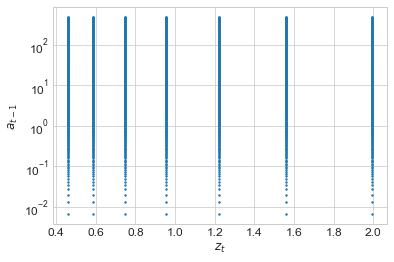

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$');

**Transition matrix for $z_t$:**

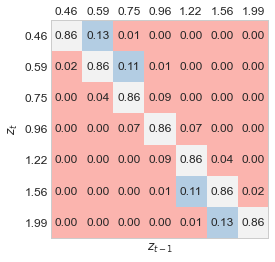

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(False)
h = ax.matshow(ss.z_trans[0],cmap='Pastel1')

for (i, j), value in np.ndenumerate(ss.z_trans[0]):
    ax.text(j, i, f'{value:0.2f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t-1}$')
ax.set_ylabel('$z_{t}$');

**Ergodic distribution:**

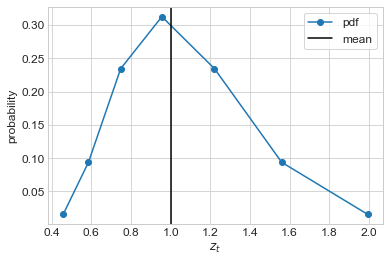

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(par.z_grid,ss.Dz[0],'-o',label='pdf')
ax.axvline(np.sum(par.z_grid*ss.Dz),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True);

## Policy functions

The steady state policy functions are in `ss.a` and `ss.c`.

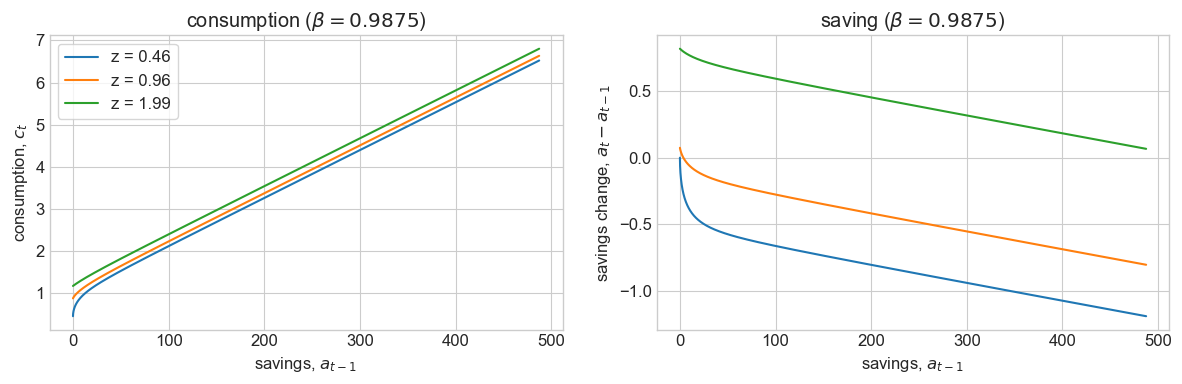

In [11]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

    fig.tight_layout()

## Simulation

The steady state distribution is in `ss.D` where `ss.D.shape == [par.Nbeta,par.Nz,par.Na]`

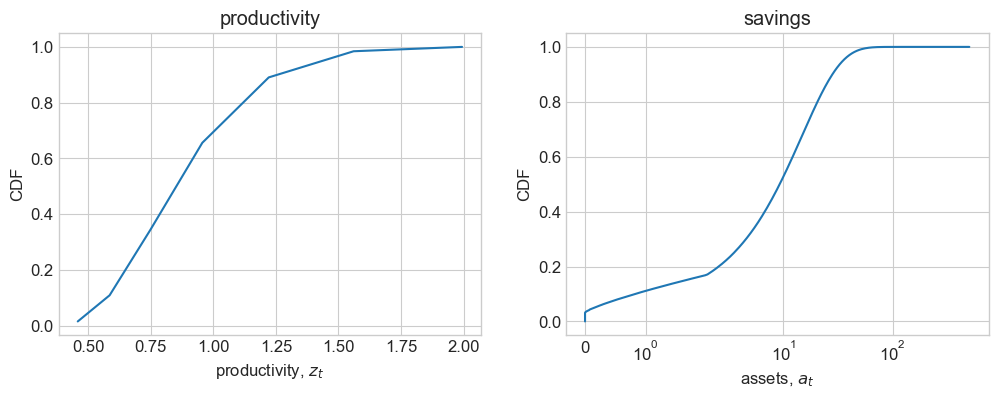

In [12]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
ax.plot(par.z_grid,np.cumsum(np.sum(ss.D,axis=(0,2))))

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0),label='discrete')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

**Income moments:**

In [13]:
mean_z = np.sum(ss.D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(ss.D*(par.z_grid[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.30


**Asset moments:**

In [14]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a: 12.509
p25  a:  3.545
p50  a:  9.274
p95  a: 35.143
p99  a: 50.170
std. a: 11.620


**MPC:**

In [15]:
MPC = np.zeros(ss.D.shape)
dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
dm = (1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = dc/dm
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

mean MPC: 0.044 [annual: 0.164]


# Tests

Here we run a couple of tests to show that the code behaves as expected. This is especially valuable when developing a new model.

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household z z simulated along transition in 0.9 secs



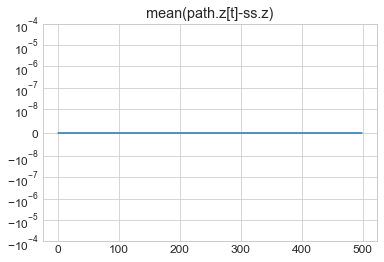

In [16]:
model.test_hh_z_path()

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.4 secs
household problem simulated along transition in 1.1 secs



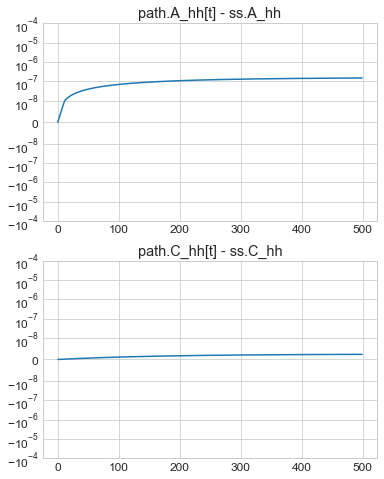

In [17]:
model.test_hh_path()

**Full transition path:**

In [18]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
Gamma          : t0 =  0.0e+00, max abs.  0.0e+00
K              : t0 =  0.0e+00, max abs.  0.0e+00
L              : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 =  1.7e-18, max abs.  1.7e-18
rk             : t0 =  0.0e+00, max abs.  0.0e+00
w              : t0 =  2.2e-16, max abs.  2.2e-16
Y              : t0 =  0.0e+00, max abs.  0.0e+00
A_hh           : t0 =  1.8e-15, max abs.  1.5e-07
C_hh           : t0 = -1.1e-15, max abs.  2.4e-09

absolute value (potential targets):
clearing_A     : t0 = -1.8e-15, max abs.  1.5e-07
clearing_C     : t0 =  9.3e-10, max abs.  1.5e-09


**Calculation of Jacobians:**

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 0.5 secs]
finding Jacobian wrt. r              : 0 125 250 375 [computed in 0.7 secs]
finding Jacobian wrt. w              : 0 125 250 375 [computed in 0.6 secs]
household Jacobian computed in 1.9 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.3 secs
curly_Y and curly_D calculated for w               in 0.3 secs
curly_E calculated in 2.1 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 2.8 secs

A_hh:
 r              : cond = 5.8e+02 [mean =  6.4e+00]
 w              : cond = 8.4e+01 [mean =  2.4e-02]

C_hh:
 r              : cond = 1.7e+02 [mean =  7.3e-02]
 w              : cond = 1.2e+02 [mean =  2.1e-03]

full Jacobian to unknowns computed in 0.2 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.2 secs [in

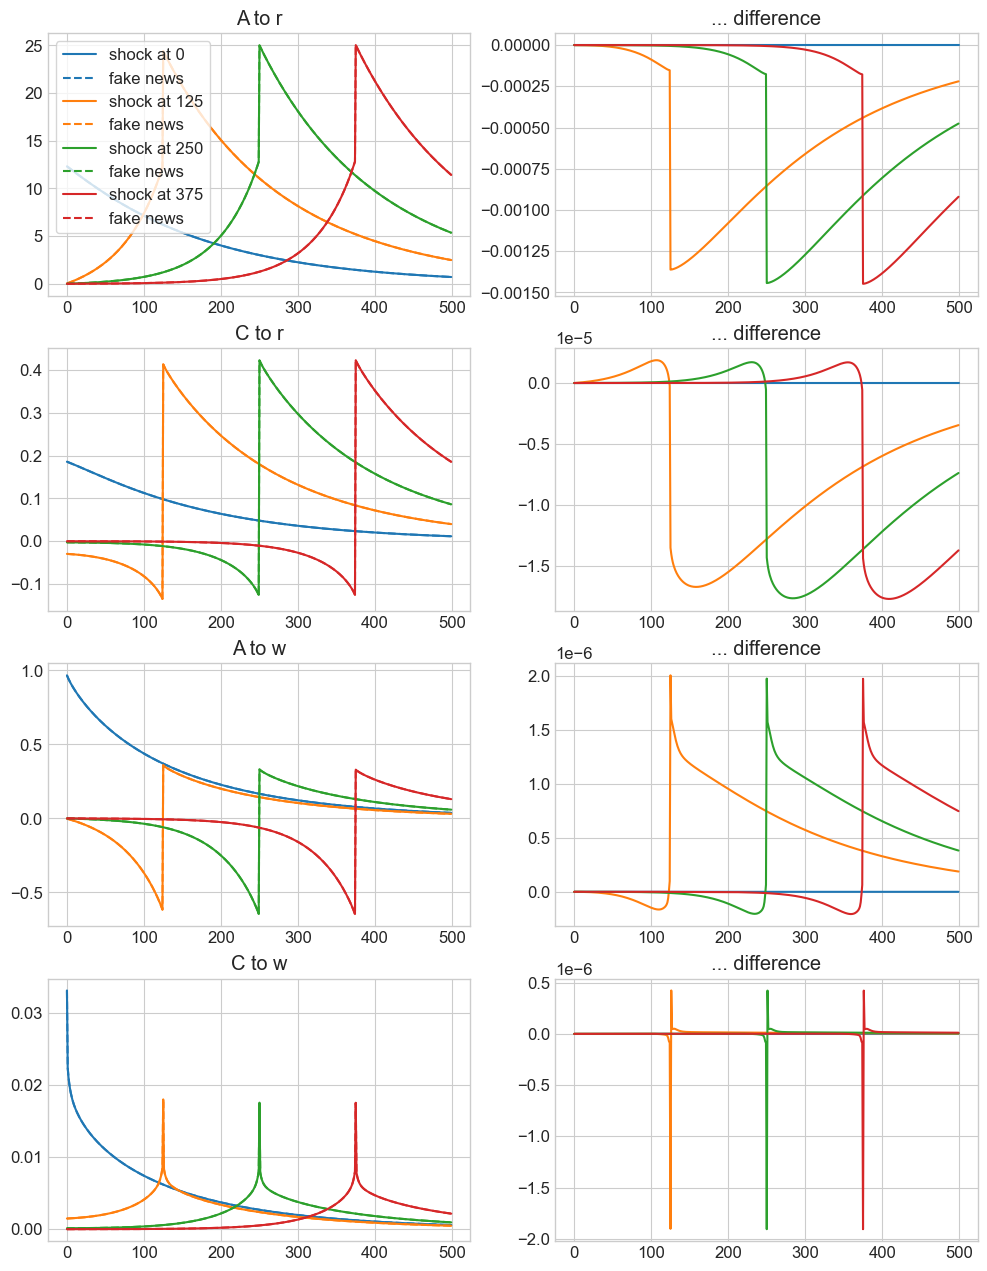

In [19]:
model.test_jacs()

# Step 2: Compute Jacobians

In [20]:
model.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are  not computed

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.3 secs
curly_Y and curly_D calculated for w               in 0.3 secs
curly_E calculated in 0.1 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 0.7 secs

full Jacobians:
full Jacobian to unknowns computed in 0.2 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.2 secs [in evaluate_path(): 0.1 secs]


The Jacobians are saved in:

1. **household Jacobians**: `model.jac_hh` is a dictionary with keys `(Outputname_hh,inputname)`
1. **full Jacobian to *unknowns***: `model.H_U` is a matrix
1. **full Jacobian to *shocks***: `model.H_Z` is a matrix
1. **full Jacobians**: `model.jac` is a dictionary with keys `(outputname,inputname)`

The **household Jacobians** are e.g. informative to look at.

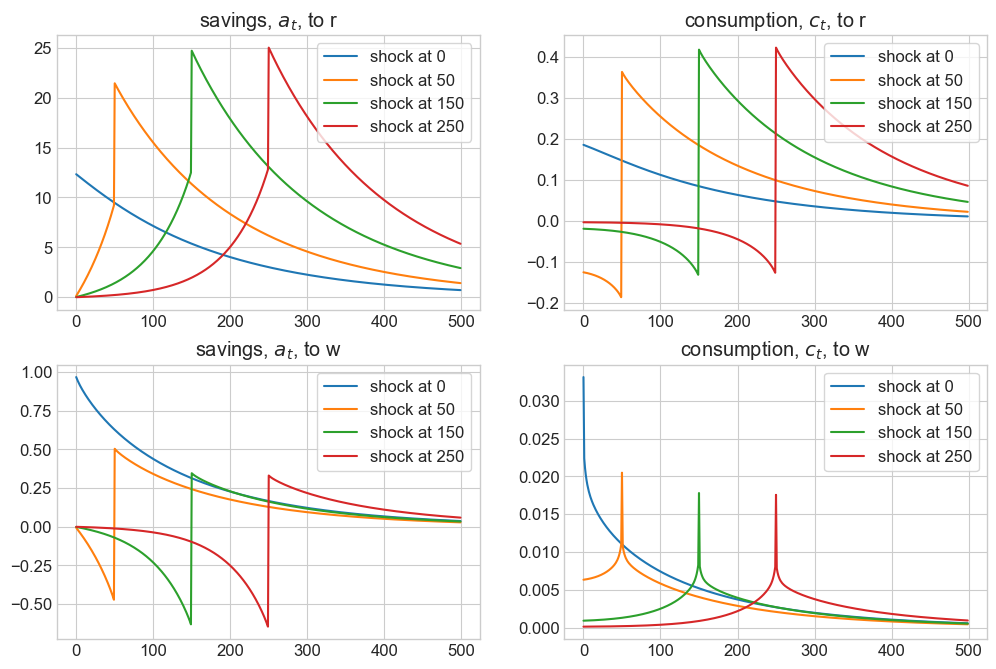

In [21]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    ax.legend(frameon=True)
    

# Step 3a: Find non-linear transition_path

In [22]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.06e-01
 it =   1 -> max. abs. error = 1.56e-04
 it =   2 -> max. abs. error = 4.95e-07
 it =   3 -> max. abs. error = 3.90e-10
 it =   4 -> max. abs. error = 4.39e-13

transition path found in 2.1 secs


**Results:** We now have

1. The transition path of all variables, `path.VARNAME[0,:]`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[0,t] == np.sum(path.a[t]*path.D[t])`.

In [23]:
diff = path.A_hh[0,:]-np.sum(path.a*path.D,axis=(1,2,3))
max_abs_diff = np.max(np.abs(diff))
print(f'{max_abs_diff = }')

max_abs_diff = 0.0


**Plot transitions**

### shocks ###


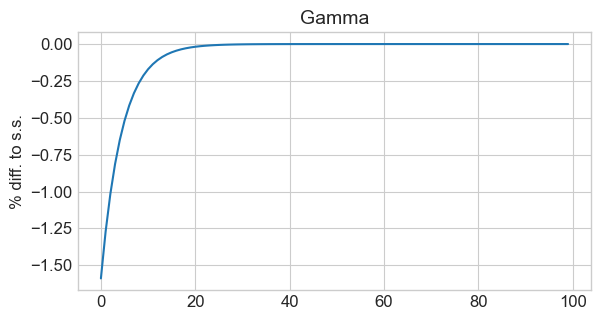


### varnames ###


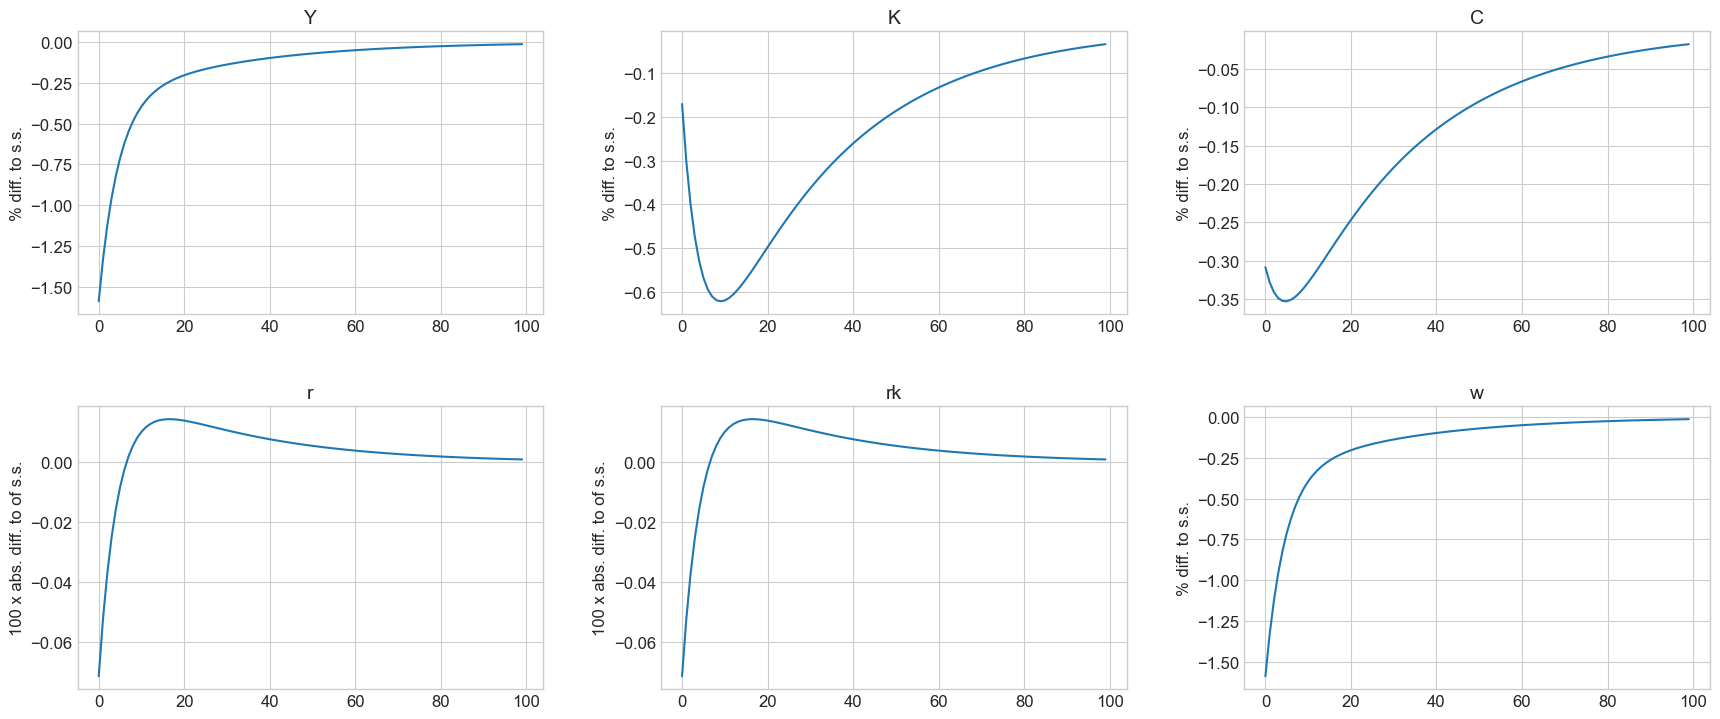


### tagets ###


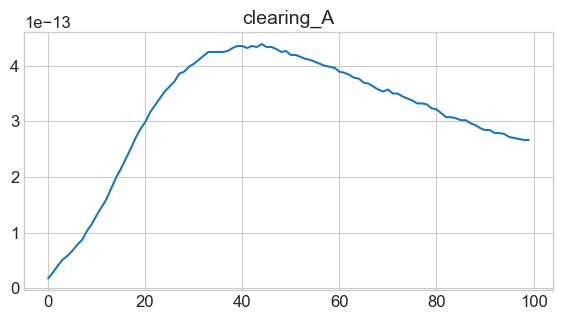

In [24]:
paths = ['Y','K','C','r','rk','w']
abs_diff = ['r','rk']
facs = {'r':100,'rk':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100)

# Step 3b: Find linearized IRFs

In [25]:
model.find_IRFs(do_print=True,reuse_G_U=False)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


**Results:** We now have `model.IRF[varname]` with the linear impulse response of all variables.

### shocks ###


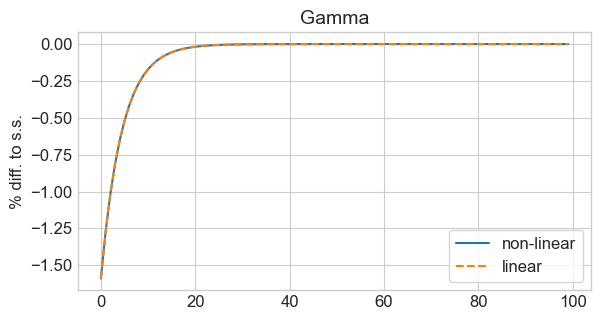


### varnames ###


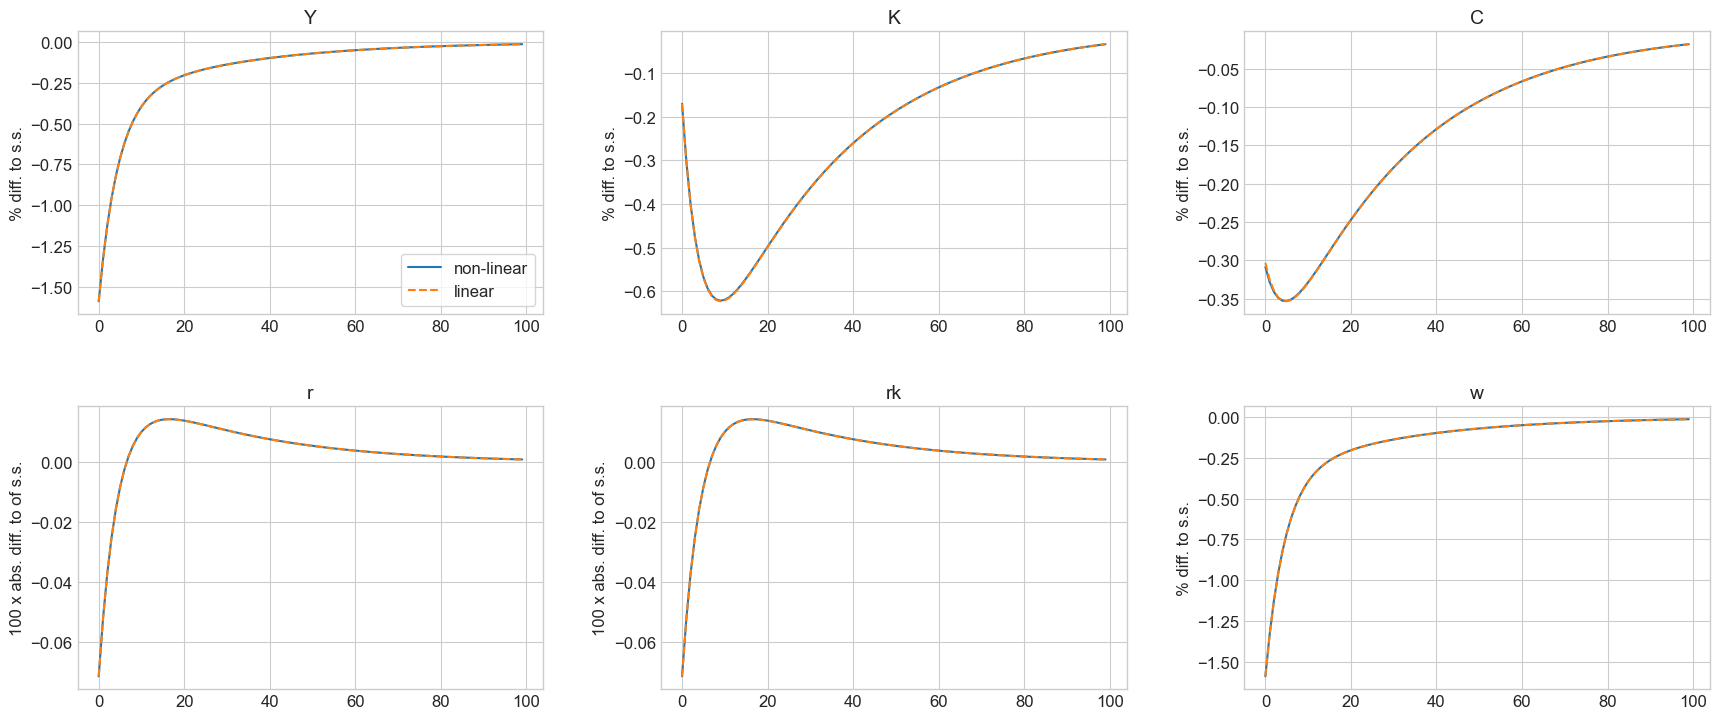


### tagets ###


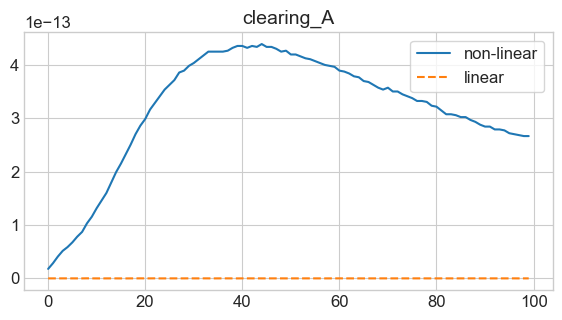

In [26]:
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,do_linear=True)

# Decomposing household behavior

**Case 1:** Behavior when only some inputs are active.

['r']
household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs

['w']
household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs

None
household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs

all
household problem simulated along transition in 0.0 secs



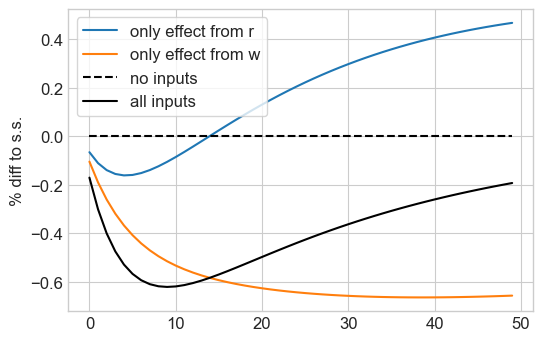

In [27]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['r'],['w'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[0,:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

**Case 2:** Behavior for a subset of households. Here those with zero assets.

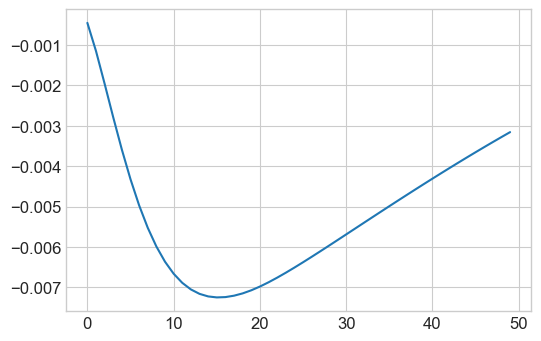

In [28]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax.plot(path_alt.A_hh[0,:50]-path_alt_ss.A_hh[0,:50]);

# Custom shock

In [29]:
# a. define shock
dGamma = np.zeros(par.T)
dGamma[:8] = 0.01
shock_specs = {'dGamma':dGamma} # note the 'd' for difference

# b. find transition path
model.find_transition_path(do_print=True,shock_specs=shock_specs)

finding the transition path:
 it =   0 -> max. abs. error = 1.87e-01
 it =   1 -> max. abs. error = 3.93e-04
 it =   2 -> max. abs. error = 1.88e-06
 it =   3 -> max. abs. error = 2.34e-09
 it =   4 -> max. abs. error = 4.16e-12

transition path found in 1.9 secs


### varnames ###


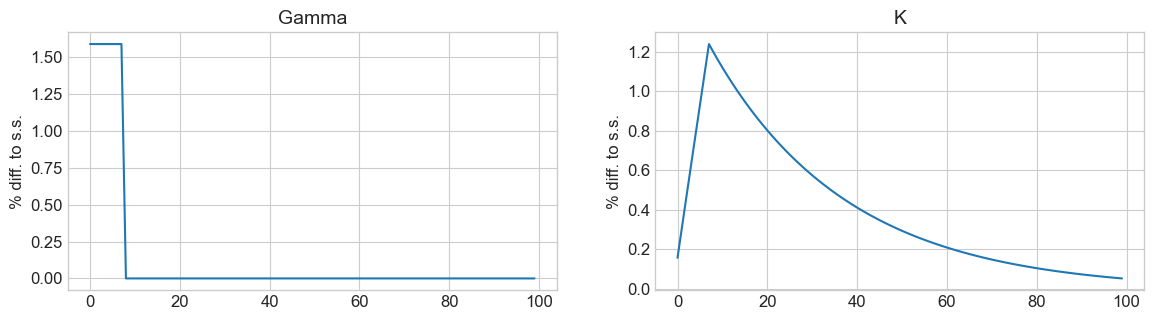

In [30]:
model.show_IRFs(['Gamma','K'],T_max=100,do_shocks=False,do_targets=False)

# Custom initial distribution

**Shock:** Assume everybody looses 10 percent of their wealth.

In [31]:
K_shock = -0.05

**Adjust distribution:**

In [32]:
ini = {}
ini['Dbeg'] = np.zeros(ss.Dbeg.shape)
for i_a_lag in range(par.Na):
    
    # a. assets after shock
    a_lag = par.a_grid[i_a_lag]
    a_lag_after = a_lag*(1+K_shock)
    
    # b. new grid point
    for i in range(par.Na-1):
        if not par.a_grid[i+1] <= a_lag_after: break
    
    # c. distribute mass
    w = (par.a_grid[i+1]-a_lag_after)/(par.a_grid[i+1]-par.a_grid[i])
    
    ini['Dbeg'][0,:,i] += w*ss.Dbeg[0,:,i_a_lag]
    ini['Dbeg'][0,:,i+1] += (1-w)*ss.Dbeg[0,:,i_a_lag]    
    

**Calculate new capital stock:**

In [33]:
ini_K = ini['K'] = np.sum(par.a_grid*ini['Dbeg'])
print(f'{ss.K  = :.3f}')
print(f'{ini_K = :.3f}')

ss.K  = 12.509
ini_K = 11.884


**Find transition with no shocks:**

In [34]:
model.find_transition_path(do_print=True,ini=ini,shock_specs={'dGamma':np.zeros(par.T)}) 

finding the transition path:
 it =   0 -> max. abs. error = 6.22e-01
 it =   1 -> max. abs. error = 4.98e-03
 it =   2 -> max. abs. error = 6.92e-05
 it =   3 -> max. abs. error = 1.51e-07
 it =   4 -> max. abs. error = 1.44e-09
 it =   5 -> max. abs. error = 2.82e-12

transition path found in 2.1 secs


### varnames ###


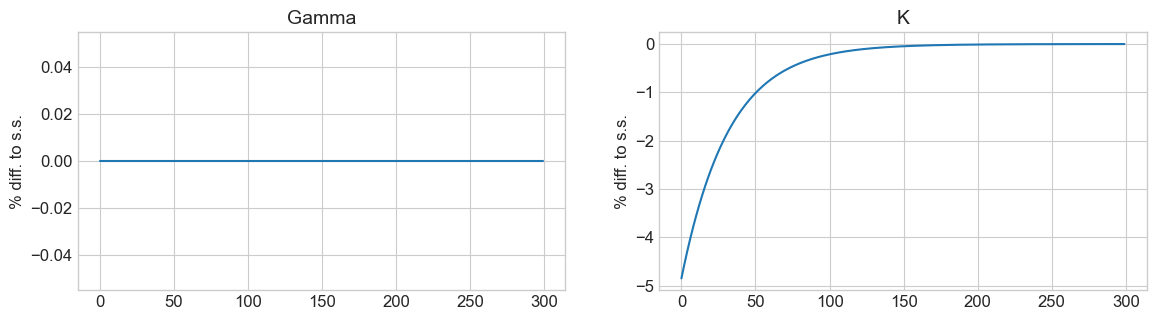

In [35]:
model.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False)

# Step 4. Simulation

In [36]:
np.random.seed(1917)
model.simulate(do_print=True)

simulation prepared in 2.6 secs [solution matrix: 0.0 secs, households: 2.5 secs]
aggregates simulated in 0.5 secs
household policies simulated in 5.7 secs
distribution simulated in 0.3 secs
aggregates calculated from distribution in 0.0 secs


In [37]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Gamma')
    ax.plot(ss.Gamma+sim.dGamma,ls='--')
    ax.axhline(ss.Gamma,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('K')
    ax.plot(ss.K+sim.dK,ls='--',)
    ax.axhline(ss.K,color='black',zorder=0)

    ax = fig.add_subplot(2,2,3)
    ax.set_title('Compare K')
    ax.plot(ss.K+sim.dK,ls='-',label='linear');
    ax.plot(model.sim.A_hh_from_D,ls='--',label='from D')
    ax.legend(frameon=True)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('... difference')
    ax.plot(model.sim.A_hh_from_D-(ss.K+sim.dK));

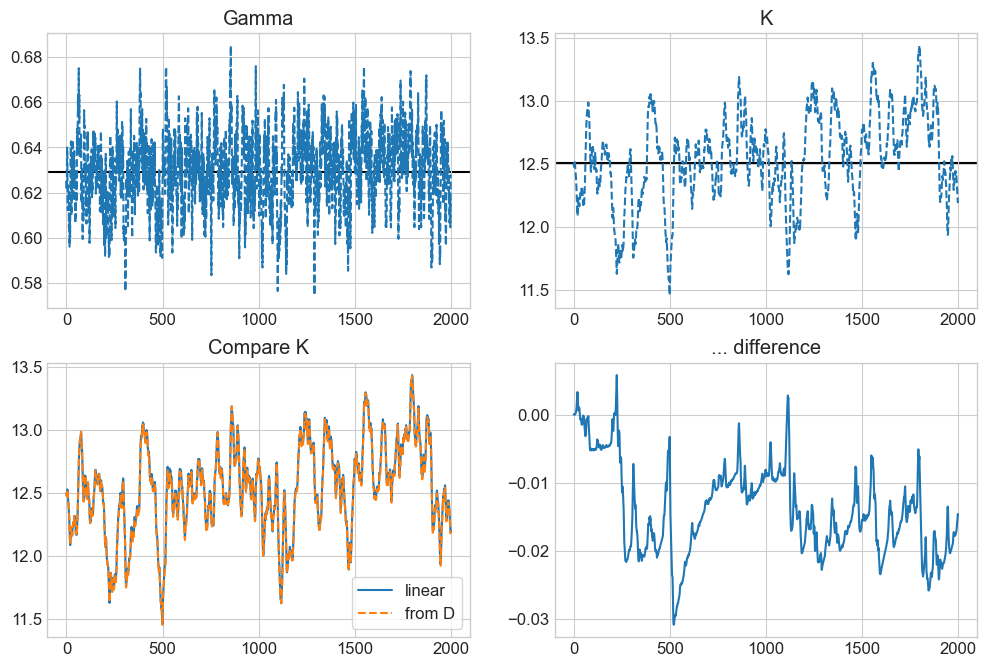

In [38]:
model_sim()

aggregates simulated in 0.0 secs
household policies simulated in 4.9 secs
distribution simulated in 0.3 secs
aggregates calculated from distribution in 0.0 secs


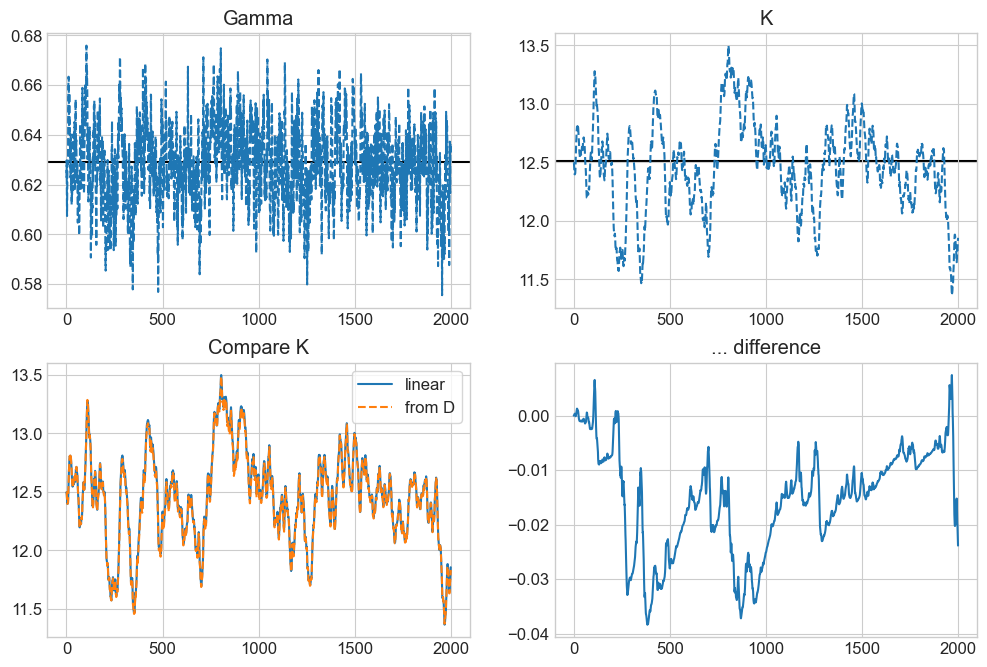

In [39]:
model.simulate(do_prepare=False,do_print=True)
model_sim()

aggregates simulated in 0.0 secs
household policies simulated in 4.7 secs
distribution simulated in 0.3 secs
aggregates calculated from distribution in 0.0 secs


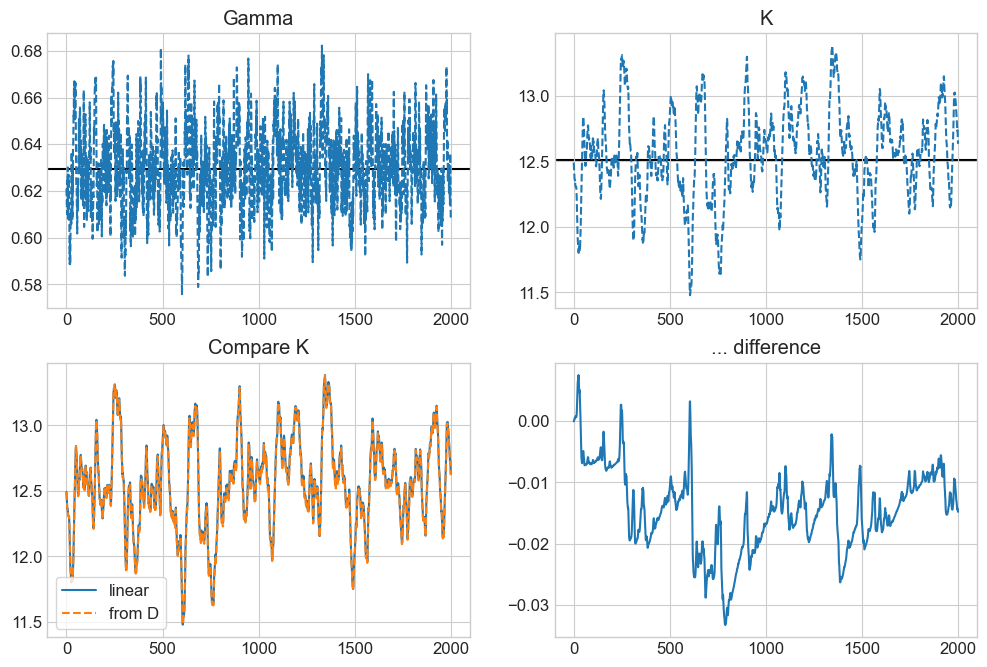

In [40]:
model.simulate(do_prepare=False,do_print=True)
model_sim()

# Speed

In [41]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 0.7 secs [1833 iterations]
household problem in ss simulated in 0.5 secs [3053 iterations]


In [42]:
model.solve_hh_path(do_print=True)
model.simulate_hh_path(do_print=True)

household problem solved along transition path in 0.2 secs
household problem simulated along transition in 0.1 secs


In [43]:
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.06e-01
 it =   1 -> max. abs. error = 1.56e-04
 it =   2 -> max. abs. error = 4.95e-07
 it =   3 -> max. abs. error = 3.90e-10
 it =   4 -> max. abs. error = 4.39e-13

transition path found in 1.9 secs


In [44]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.3 secs
curly_Y and curly_D calculated for w               in 0.3 secs
curly_E calculated in 0.2 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 0.8 secs

full Jacobians:
full Jacobian to unknowns computed in 0.2 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.2 secs [in evaluate_path(): 0.1 secs]


In [45]:
model.find_IRFs(do_print=True)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


In [46]:
model.compute_jacs(do_print=True,skip_shocks=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.3 secs
curly_Y and curly_D calculated for w               in 0.3 secs
curly_E calculated in 0.1 secs
builiding blocks combined in 0.1 secs
household Jacobian computed in 0.8 secs

full Jacobians:
full Jacobian to unknowns computed in 0.2 secs [in evaluate_path(): 0.1 secs]


In [47]:
model.compute_jacs(do_print=True,skip_hh=True)

full Jacobians:
full Jacobian to unknowns computed in 0.2 secs [in evaluate_path(): 0.1 secs]
full Jacobian to shocks computed in 0.2 secs [in evaluate_path(): 0.1 secs]


In [48]:
model.simulate(do_print=True,skip_hh=True)

simulation prepared in 0.0 secs [solution matrix: 0.0 secs]
aggregates simulated in 0.0 secs


In [49]:
model.simulate(do_print=True,skip_hh=True,reuse_G_U=True)

simulation prepared in 0.0 secs [solution matrix: 0.0 secs]
aggregates simulated in 0.0 secs


# Misc.

We can print the **unpacking code lines** typically used in the begining of `block_pre()` and `block_post()`.

In [50]:
model.print_unpack_varlist()

    for ncol in range(ncols):

        # unpack
        A = path.A[ncol,:]
        C = path.C[ncol,:]
        clearing_A = path.clearing_A[ncol,:]
        clearing_C = path.clearing_C[ncol,:]
        Gamma = path.Gamma[ncol,:]
        K = path.K[ncol,:]
        L = path.L[ncol,:]
        r = path.r[ncol,:]
        rk = path.rk[ncol,:]
        w = path.w[ncol,:]
        Y = path.Y[ncol,:]
        A_hh = path.A_hh[ncol,:]
        C_hh = path.C_hh[ncol,:]


We can update the **update aggregate settings** and automatically reallocate everything:

In [51]:
model.update_aggregate_settings(unknowns=None,shocks=None,targets=None)